# Predict with pre-trained models

This is a demo for predicting with a pre-trained model on the full imagenet dataset, which contains over 10 million images and 10 thousands classes. For a more detailed explanation, please refer to [predict.ipynb](https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb).

We first load the synset label file and pre-trained model.

In [16]:
import os, urllib
import mxnet as mx
from modelzoo import download_model

path='http://data.mxnet.io/models/imagenet-11k/'
path='http://data.mxnet.io/models/imagenet/'
def download(url,prefix=''):
    filename = prefix+url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.urlretrieve(url, filename)
        
def load_model(model_name, viz=False):
    (prefix, epoch) = download_model(model_name, dst_dir='models')
    sym, arg_params, aux_params = mx.model.load_checkpoint(prefix, epoch)
    mod = mx.mod.Module(symbol=sym, context=mx.gpu())
    mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
    mod.set_params(arg_params, aux_params)
    return (sym, mod)

#download(path+'resnet-152/resnet-152-symbol.json', 'full-')
#download(path+'resnet-152/resnet-152-0000.params', 'full-')
# first download 
download('http://data.mxnet.io/models/imagenet/synset.txt', 'imagenet-')
download('http://data.mxnet.io/models/imagenet-11k/synset.txt', 'imagenet-11k-')
with open('imagenet-synset.txt', 'r') as f:
    imagenet_synsets = [l.rstrip() for l in f]
with open('imagenet-11k-synset.txt', 'r') as f:
    imagenet_11k_synsets = [l.rstrip() for l in f]

resnet, resnet_mod = load_model('imagenet1k-resnet-50', True)

Create a model for this model on GPU 0.

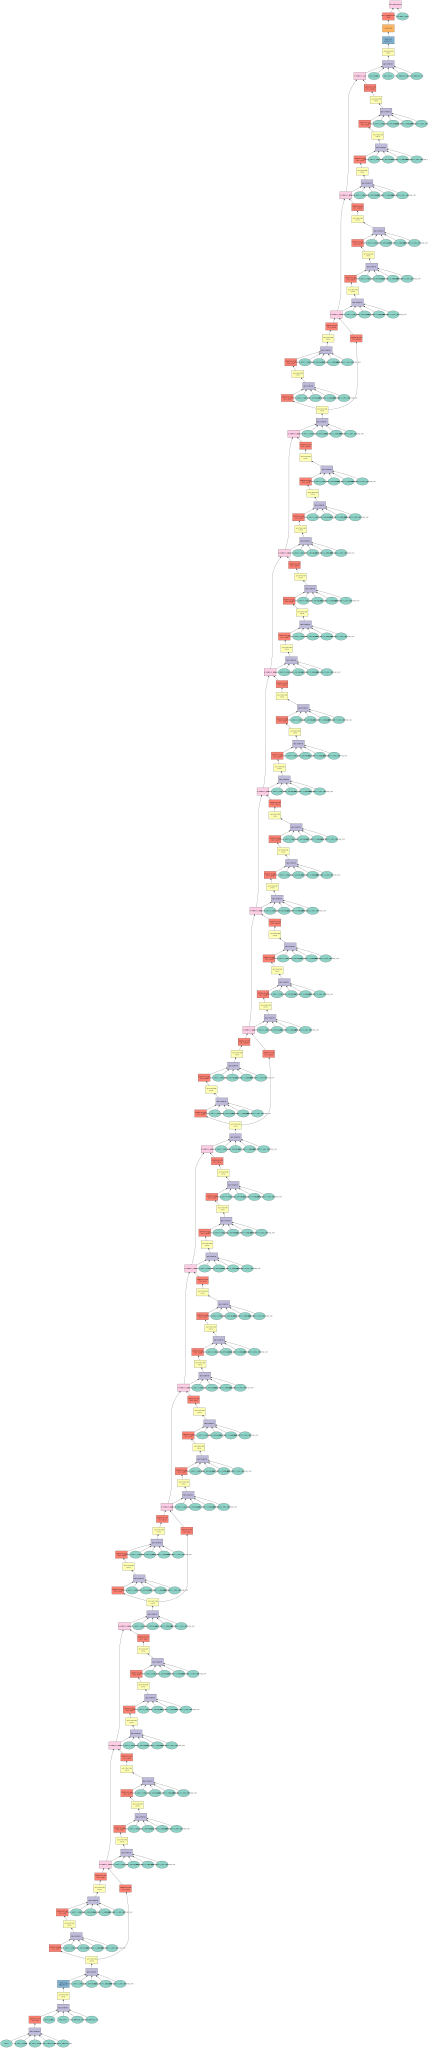

In [17]:
mx.viz.plot_network(resnet)

Next we define the function to obtain an image by a given URL and the function for predicting.

In [7]:
%matplotlib inline
import matplotlib
matplotlib.rc("savefig", dpi=100)
import matplotlib.pyplot as plt
import cv2
import numpy as np
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def get_image(url, show=True):
    filename = url.split("/")[-1]
    urllib.urlretrieve(url, filename)
    img = cv2.imread(filename)
    if img is None:
        print('failed to download ' + url)
    if show:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    return filename

def predict(filename, mod, synsets):
    img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    if img is None:
        return None
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2) 
    img = img[np.newaxis, :] 
    
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    prob = np.squeeze(prob)

    a = np.argsort(prob)[::-1]    
    for i in a[0:5]:
        print('probability=%f, class=%s' %(prob[i], synsets[i]))
    

We are able to classify an image and output the top predicted classes. 

In [18]:
url = 'http://writm.com/wp-content/uploads/2016/08/Cat-hd-wallpapers.jpg'
predict(get_image(url), resnet_model, imagenet_synsets)

probability=0.418679, class=n02119789 kit fox, Vulpes macrotis
probability=0.293495, class=n02119022 red fox, Vulpes vulpes
probability=0.029321, class=n02120505 grey fox, gray fox, Urocyon cinereoargenteus
probability=0.026230, class=n02124075 Egyptian cat
probability=0.022557, class=n02085620 Chihuahua


RuntimeError: Could not create write struct

In [11]:
url = 'https://images-na.ssl-images-amazon.com/images/G/01/img15/pet-products/small-tiles/23695_pets_vertical_store_dogs_small_tile_8._CB312176604_.jpg'
predict(get_image(url), resnet_model, imagenet_synsets)

probability=0.935154, class=n02088364 beagle
probability=0.034125, class=n02089867 Walker hound, Walker foxhound
probability=0.013201, class=n02089973 English foxhound
probability=0.006125, class=n04409515 tennis ball
probability=0.003187, class=n02088238 basset, basset hound


RuntimeError: Could not create write struct